## Setting up the problem

As an example of a place where Cython can really shine, we're going to look at numerical integration of an orbit under the influence of some external gravitational potential. 

...

Leapfrog...

Let's first implement the orbit calculation in pure-Python:

In [14]:
from astropy.constants import G
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# the unit system we'll use
units = [u.Myr, u.kpc, u.Msun]
_G = G.decompose(units).value

$$
\begin{align}
    \Phi(r) &= -\frac{G\,m}{r + a} \\
    \frac{{\rm d}\Phi}{{\rm d}r} &= \frac{G\,m}{(r + a)^2} \\
    \frac{{\rm d}\Phi}{{\rm d}x} &= \frac{{\rm d}\Phi}{{\rm d}r} \, \frac{x}{r}
\end{align}
$$

In [25]:
# parameters in the gravitational potential
m = 1E11 # Msun
a = 1. # kpc

We'll work in 3D Cartesian coordinates, so we need to write a function to compute the acceleration in the x, y, z components:

In [27]:
def hernquist_acceleration(xyz, G, m, a):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    return -dPhi_dr * xyz / r

In [45]:
def leapfrog_hernquist(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * hernquist_acceleration(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = hernquist_acceleration(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In [46]:
t, x, v = leapfrog_hernquist(x0=[10., 0, 0], v0=[0, 0.2, 0],
                             dt=1., n_steps=10000, 
                             hernquist_args=(_G, m, a))

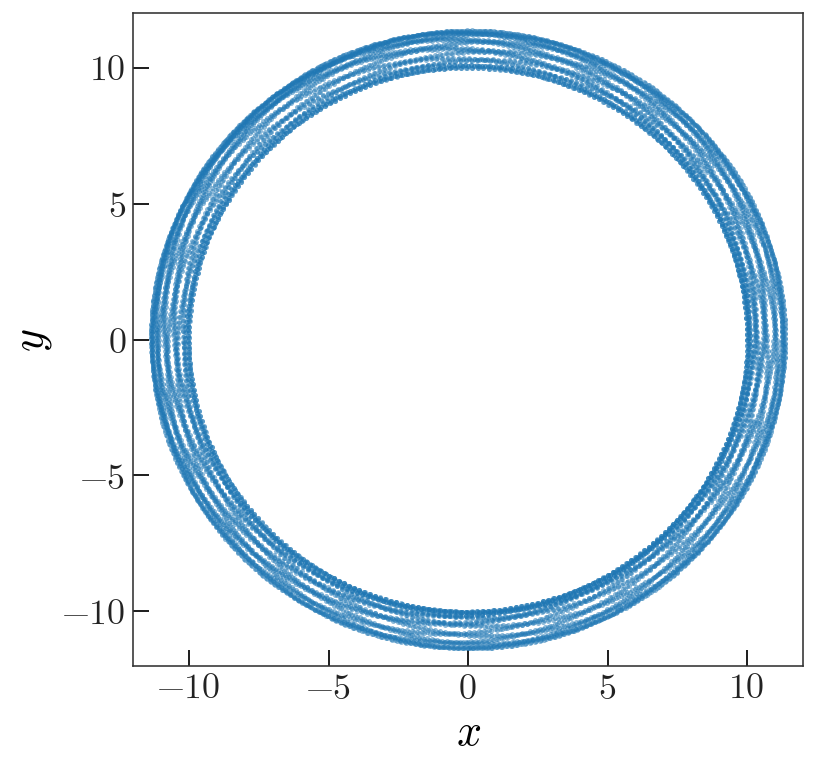

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(x[:,0], x[:,1], marker='.', linestyle='none', alpha=0.5)
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [49]:
%%timeit
leapfrog_hernquist(x0=[10., 0, 0], v0=[0, 0.2, 0],
                   dt=1., n_steps=10000, 
                   hernquist_args=(_G, m, a))

10 loops, best of 3: 149 ms per loop


This is already pretty fast, but what if we need to integrate thousands of orbits simultaneously? More complicated potential models? N-body?

- No way to optimize with array operations - need loops

In [6]:
%load_ext Cython

We'll write the same thing in Cython but with no changes other than to compile it with Cython:

In [55]:
%%cython

import numpy as np

def acc_cy1(xyz, G, m, a):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    return -dPhi_dr * xyz / r

def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In [56]:
%%timeit
leapfrog_cy1([10., 0, 0], [0, 0.2, 0],
             dt=1., n_steps=10000, 
             hernquist_args=(_G, m, a))

10 loops, best of 3: 139 ms per loop


OK, so as you might expect, we didn't change anything so we didn't get any improvement in speed. Why is that? Even though we compile it to C using Cython, it's still going through a Python layer. Python is written in C, so the generated C code is actually what Python uses to execute any code! One way we can see this is to use Cython's "annotate" feature to look at what lines hit the Python layer (and thus slow us down). This is the exact same cell as above, but with `--annotate` added after the Cython magic:

In [57]:
%%cython --annotate

import numpy as np

def acc_cy1(xyz, G, m, a):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    return -dPhi_dr * xyz / r

def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In the above, everything yellow hints at interaction with the Python layer. We can click on a given line to see the C code it generates.

---

So how do we make this faster? Or, how do we remove the interaction with the Python layer? Cython will do this automatically if we write our code to look more like C. This means adding explicit types, and telling Cython to remove some of the nice features of Python like array index bounds checking. Let's start by re-writing our acceleration function to declare types and remove as much Python overhead as possible:

In [64]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

def acc_cy2(double[::1] xyz, double G, double m, double a):
    cdef:
        double r
        double dPhi_dr
        double[::1] a_xyz = np.zeros(3, np.float64)
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
    return a_xyz

So why are so many of the lines still yellow? Let's take a look at one of them. 

Many of the lines call "`RaiseBufferIndexError`". This is